In [184]:
### allows to direct changes in the packages to be immidiately visibe in the notebook 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
import os, sys
sys.path.append(os.getcwd() + '/../..')
sys.path.append(os.getcwd() + '/..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime
import helper_v1 as helper

from matplotlib import pyplot as plt 

from merf.merf import MERF
from sklearn.model_selection import cross_val_score, train_test_split

import skopt
from skopt.space import Real, Integer, Categorical
import itertools
from skopt import gp_minimize
import gc

In [248]:
df_data = pd.read_csv('./data/cell/traffic_cells.csv', sep='|', encoding="UTF-8",
                    warn_bad_lines=False, error_bad_lines=False, header=0, index_col=0)

df_data.ds = pd.to_datetime(df_data.ds)
df_data.rounded_dt = pd.to_datetime(df_data.rounded_dt)

C:\ProgramData\Anaconda3\envs\shared\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [249]:
df_data.head()

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb,rounded_dt
1057716,0,2019-01-02 00:00:00,15.076,853.171461,2019-01-02 00:00:00
1049620,0,2019-01-02 00:15:00,17.461,993.111915,2019-01-02 00:00:00
725344,0,2019-01-02 00:30:00,9.163,266.322692,2019-01-02 00:00:00
1072162,0,2019-01-02 00:45:00,12.535,318.778401,2019-01-02 00:00:00
1078715,0,2019-01-02 01:00:00,13.531,393.152370,2019-01-02 01:00:00


### To reduce the number of records, I am aggregating on hourly basis

In [250]:
df_data = df_data.groupby(['cell_key','rounded_dt']).mean().reset_index()
df_data.columns = ['cell_key', 'ds', 'prb_dl_used_avg', 'thrp_dl_mb']

In [251]:
df_data

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb
0,0,2019-01-02 00:00:00,13.55875,607.846117
1,0,2019-01-02 01:00:00,9.75725,276.166865
2,0,2019-01-02 02:00:00,9.70875,190.218932
3,0,2019-01-02 03:00:00,18.19025,365.520157
4,0,2019-01-02 04:00:00,2.27425,56.571423
...,...,...,...,...
272563,80,2019-06-01 19:00:00,7.28900,260.747239
272564,80,2019-06-01 20:00:00,6.95925,312.498765
272565,80,2019-06-01 21:00:00,6.86275,214.913249
272566,80,2019-06-01 22:00:00,11.30275,403.033508


In [252]:
df_data.dtypes

cell_key                    int64
ds                 datetime64[ns]
prb_dl_used_avg           float64
thrp_dl_mb                float64
dtype: object

#### We have 81 unique cells logging the data

In [253]:
df_data.cell_key.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

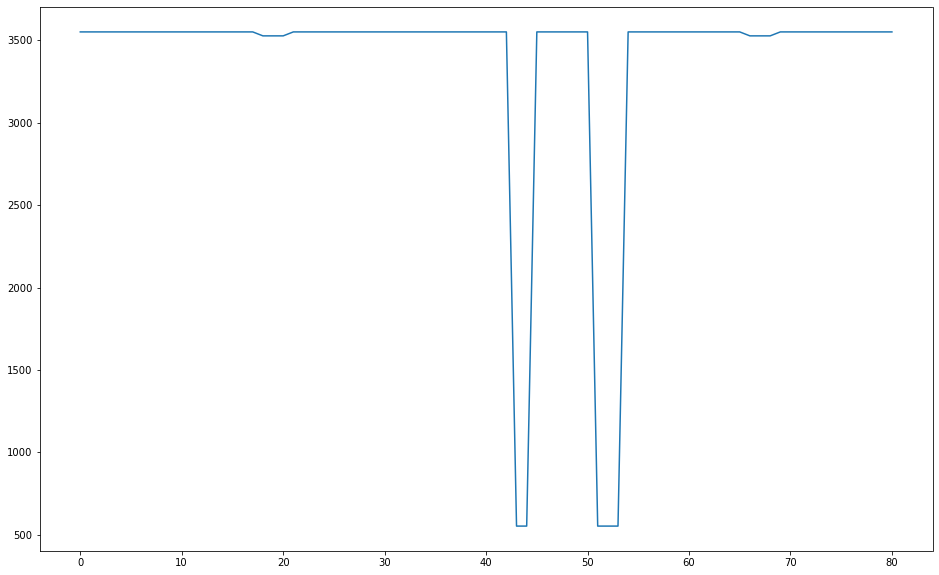

In [212]:
fig = plt.figure(figsize=(16,10))
plt.plot(df_data.groupby(['cell_key'])['ds'].count())

#### Five cells have data for fewer days

In [213]:
df_data.groupby(['cell_key'])['ds'].count().sort_values()[0:20]

cell_key
44     552
43     552
53     552
51     552
52     552
20    3528
19    3528
18    3528
66    3528
67    3528
68    3528
58    3552
49    3552
48    3552
54    3552
55    3552
56    3552
57    3552
47    3552
46    3552
Name: ds, dtype: int64

#### Lets see how it looks for one cell

In [214]:
one_cell_only = df_data[df_data.cell_key==0]

In [215]:
fig = plt.figure(figsize=(20,16))
plt.plot(one_cell_only.ds[0:200], one_cell_only.y[0:200])

AttributeError: 'DataFrame' object has no attribute 'y'

<Figure size 1440x1152 with 0 Axes>

## Lets prepare the data and add additional fields/information/columns

#### Day of a Week gives importatn insight here since traffic on weekends are higher compared to normal week days therefore, we explicitly specify day of week 

In [254]:
df_data['week_days'] = df_data['ds'].apply(helper.is_weekend)
df_data['week_ends'] = ~df_data['ds'].apply(helper.is_weekend)

In [255]:
df_data

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb,week_days,week_ends
0,0,2019-01-02 00:00:00,13.55875,607.846117,True,False
1,0,2019-01-02 01:00:00,9.75725,276.166865,True,False
2,0,2019-01-02 02:00:00,9.70875,190.218932,True,False
3,0,2019-01-02 03:00:00,18.19025,365.520157,True,False
4,0,2019-01-02 04:00:00,2.27425,56.571423,True,False
...,...,...,...,...,...,...
272563,80,2019-06-01 19:00:00,7.28900,260.747239,False,True
272564,80,2019-06-01 20:00:00,6.95925,312.498765,False,True
272565,80,2019-06-01 21:00:00,6.86275,214.913249,False,True
272566,80,2019-06-01 22:00:00,11.30275,403.033508,False,True


#### Traffic patterns are also different on holidays compared to normal working days therefore, the holiday data is also added

In [256]:
df_holidays = helper.get_national_holidays(year=2019)
df_holidays

,holiday,ds,lower_window,upper_window
0,New year,2019-01-01,0,1
1,Epiphany,2019-01-06,0,1
2,Easter Monday,2019-04-22,0,1
3,State Holiday,2019-05-01,0,1
4,Ascension Thursday,2019-05-30,0,1
5,Whit Monday,2019-06-10,0,1
6,Corpus Christi,2019-06-20,0,1
7,Assumption of Mary to Heaven,2019-08-15,0,1
8,National Holiday,2019-10-26,0,1
9,All Saints Day,2019-11-01,0,1


#### Depending upon what series is going on, the network traffic varies alot as well, so it is usefull to add this info. as well, there are many free sites from where such data can be donwloaded

In [257]:
match_dates = helper.get_matchdates()
conditions = df_data.ds.isin(match_dates.DateTimeAdj)

In [258]:
#df_data['game_played'] = np.select(conditions, df_data.ds)

In [259]:
df_data

,cell_key,ds,prb_dl_used_avg,thrp_dl_mb,week_days,week_ends
0,0,2019-01-02 00:00:00,13.55875,607.846117,True,False
1,0,2019-01-02 01:00:00,9.75725,276.166865,True,False
2,0,2019-01-02 02:00:00,9.70875,190.218932,True,False
3,0,2019-01-02 03:00:00,18.19025,365.520157,True,False
4,0,2019-01-02 04:00:00,2.27425,56.571423,True,False
...,...,...,...,...,...,...
272563,80,2019-06-01 19:00:00,7.28900,260.747239,False,True
272564,80,2019-06-01 20:00:00,6.95925,312.498765,False,True
272565,80,2019-06-01 21:00:00,6.86275,214.913249,False,True
272566,80,2019-06-01 22:00:00,11.30275,403.033508,False,True


In [260]:
#df_data.index = pd.to_datetime(df_data.ds)

In [261]:
df_data.columns = ['cell_key', 'ds','prb_dl_used_avg', 'y', 'week_days', 'week_ends']

In [262]:
temp = df_data[df_data['cell_key']<5]

In [263]:
df_X = temp[['ds', 'cell_key','prb_dl_used_avg', 'week_days', 'week_ends']]
#df_X.index = df_X.reset_index()
df_y = temp[['y']]

### Let's fit the model

In [264]:
df_X

,ds,cell_key,prb_dl_used_avg,week_days,week_ends
0,2019-01-02 00:00:00,0,13.55875,True,False
1,2019-01-02 01:00:00,0,9.75725,True,False
2,2019-01-02 02:00:00,0,9.70875,True,False
3,2019-01-02 03:00:00,0,18.19025,True,False
4,2019-01-02 04:00:00,0,2.27425,True,False
...,...,...,...,...,...
17755,2019-06-01 19:00:00,4,11.35500,False,True
17756,2019-06-01 20:00:00,4,5.45575,False,True
17757,2019-06-01 21:00:00,4,7.85000,False,True
17758,2019-06-01 22:00:00,4,8.61350,False,True


In [265]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.20, random_state=42)


In [266]:
X_train

,ds,cell_key,prb_dl_used_avg,week_days,week_ends
15610,2019-03-02 10:00:00,4,12.360250,False,True
5230,2019-03-14 22:00:00,1,18.530750,True,False
15224,2019-02-13 08:00:00,4,21.039250,True,False
83,2019-01-05 11:00:00,0,16.365250,False,True
14570,2019-01-17 02:00:00,4,1.936250,True,False
...,...,...,...,...,...
11284,2019-01-28 04:00:00,3,0.823500,True,False
11964,2019-02-25 12:00:00,3,3.490250,True,False
5390,2019-03-21 14:00:00,1,56.486250,True,False
860,2019-02-06 20:00:00,0,43.259251,True,False


In [274]:
#y_train
X_train

,ds,cell_key,prb_dl_used_avg,week_days,week_ends
15610,2019-03-02 10:00:00,4,12.360250,False,True
5230,2019-03-14 22:00:00,1,18.530750,True,False
15224,2019-02-13 08:00:00,4,21.039250,True,False
83,2019-01-05 11:00:00,0,16.365250,False,True
14570,2019-01-17 02:00:00,4,1.936250,True,False
...,...,...,...,...,...
11284,2019-01-28 04:00:00,3,0.823500,True,False
11964,2019-02-25 12:00:00,3,3.490250,True,False
5390,2019-03-21 14:00:00,1,56.486250,True,False
860,2019-02-06 20:00:00,0,43.259251,True,False


#### Covariate with possible random effect:
##### cell_key

In [286]:
clusters_train = X_train['cell_key']

In [287]:
X_train_merf = X_train.drop(['cell_key', 'ds'], axis=1)

In [288]:
Z_train = np.ones(shape=(X_train.shape[0],1))

In [289]:
#Z_train = Z_train.astype(int)

In [290]:
y_train

,y
15610,540.244088
5230,1297.907507
15224,624.192543
83,423.214877
14570,85.878055
...,...
11284,0.462981
11964,157.644424
5390,1539.857215
860,1595.006935


In [292]:
mrf = MERF(max_iterations=500)
mrf.fit(X_train_merf, Z_train, clusters_train, y_train)

ValueError: Unable to coerce to Series, length must be 1: given 2854

#### Lets seperate train from test. I added last 7 entries (quarters) as test data